# 선언

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

from torch.utils.data import DataLoader, Dataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
import pyaudio 

import os

In [18]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

In [3]:
print (f"PyTorch version:{torch.__version__}")
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}")
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.4.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.6.1-arm64-arm-64bit


# 데이터 전처리

1. 소음 구간 태깅

2. 데이터 분할

In [4]:
class NoiseDataset(Dataset):
    def __init__(self, audio_file, sample_rate = 44100, frame_size = 1024, threshold = 0.05):
        waveform, orig_sample_rate = torchaudio.load(audio_file)
        self.waveform = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)(waveform)
        self.sample_rate = sample_rate
        self.frame_size = frame_size
        self.threshold = threshold
        self.noise_indices = self._detect_noise(self.waveform)
        
    def _detect_noise(self, waveform):
        noise_indices = []
        energy = waveform.pow(2).mean(dim=0)
        for i in range(0, waveform.size(1) - self.frame_size, self.frame_size):
            frame_energy = energy[i:i+self.frame_size].mean().item()
            if frame_energy > self.threshold:
                noise_indices.append(i)
        return noise_indices

    def __len__(self):
        return len(self.noise_indices)
    
    def __getitem__(self, idx):
        start_idx = self.noise_indices[idx]
        end_idx = start_idx + self.frame_size
        noisy_segment = self.waveform[:, start_idx:end_idx]
        return noisy_segment, noisy_segment


# LSTM 모델

In [5]:
class AntiNoiseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AntiNoiseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# 학습 및 평가

In [10]:
# def train_model(dataloader, model, criterion, optimizer, num_epochs = 10, validation_loader = None):
#     train_losses = []
#     val_losses = []

#     model.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
        
#         for i, (inputs, targets) in enumerate(dataloader):
#             inputs = inputs.to(device)
#             targets = targets.to(device)

#             if inputs.dim() == 2: 
#                 inputs = inputs.unsqueeze(1) 
#             elif inputs.dim() == 4:  
#                 inputs = inputs.squeeze(-1) 
#             elif inputs.dim() != 3: 
#                 raise ValueError(f"Unexpected input dimension {inputs.dim()} with shape {inputs.shape}")

#             inputs = inputs.float()
#             targets = -inputs
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#             if (i + 1) % 10 == 0:
#                 print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        
#         epoch_loss = running_loss / len(dataloader)
#         train_losses.append(epoch_loss)

#         if validation_loader is not None:
#             val_loss = evaluate_model(validation_loader, model, criterion)
#             val_losses.append(val_loss)
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
#         else:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')
    
#     return train_losses, val_losses

# def evaluate_model(dataloader, model, criterion):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.unsqueeze(-1).float()
#             targets = targets.unsqueeze(-1).float()

#             outputs = model(inputs)
#             outputs = outputs.unsqueeze(-1)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
    
#     return total_loss / len(dataloader)

### vol2

In [6]:
def train_model(dataloader, model, criterion, optimizer, num_epochs = 10, validation_loader=None):
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        
        for i, (inputs, targets) in enumerate(dataloader):
            if inputs.dim() == 4:
                # 입력 데이터가 4D인 경우, (batch, channels, seq_len, input_size)
                batch_size, channels, seq_len, input_size = inputs.shape
                # LSTM이 기대하는 입력 형태로 변환
                inputs = inputs.view(batch_size * channels, seq_len, input_size).float()
            elif inputs.dim() == 3:
                # 입력 데이터가 이미 3D인 경우, (batch, seq_len, input_size)
                inputs = inputs.float()
            else:
                raise ValueError(f"Unexpected input dimensions: {inputs.shape}")

            # 타겟 데이터도 적절히 float으로 변환
            targets = -inputs
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        
        
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)

        if validation_loader is not None:
            val_loss = evaluate_model(validation_loader, model, criterion)
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')
    
    return train_losses, val_losses

def evaluate_model(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.unsqueeze(-1).float()
            targets = -inputs

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    if val_losses:
        plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [7]:
def train_model(dataloader, model, criterion, optimizer, num_epochs = 10, validation_loader=None):
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        
        for i, (inputs, targets) in enumerate(dataloader):
            if inputs.dim() == 4:
                # 입력 데이터가 4D인 경우, (batch, channels, seq_len, input_size)
                batch_size, channels, seq_len, input_size = inputs.shape
                # LSTM이 기대하는 입력 형태로 변환
                inputs = inputs.view(batch_size * channels, seq_len, input_size).float()
            elif inputs.dim() == 3:
                # 입력 데이터가 이미 3D인 경우, (batch, seq_len, input_size)
                inputs = inputs.float()
            else:
                raise ValueError(f"Unexpected input dimensions: {inputs.shape}")

            # 타겟 데이터도 적절히 float으로 변환
            targets = -inputs
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        
        
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')
    
    return train_losses

def evaluate_model(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # 입력 데이터 차원에 따른 전처리
            if inputs.dim() == 4:
                # 4D 텐서인 경우: (batch_size, channels, seq_len, input_size)
                batch_size, channels, seq_len, input_size = inputs.shape
                inputs = inputs.view(batch_size * channels, seq_len, input_size).float()  # 3D로 변환
            elif inputs.dim() == 3:
                # 3D 텐서인 경우: (batch_size, seq_len, input_size)
                inputs = inputs.float()
            else:
                raise ValueError(f"Unexpected input dimensions: {inputs.shape}")

            targets = -inputs

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    if val_losses:
        plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# 파라미터 선언

In [8]:
val = {
    'input_size' : 1024,
    'hidden_size' : 512,
    'num_layers' : 2,
    'output_size' : 1024,
    'learning_rate' : 0.001
}

# 데이터 불러오기

In [10]:
def load_datasets_from_folder(folder_path, sample_rate=44100, frame_size=1024, threshold=0.05):
    """
    Parameters:
    - folder_path (str): .wav 파일이 있는 폴더의 경로
    - sample_rate (int): 샘플링 속도
    - frame_size (int): 프레임 크기
    - threshold (float): 소음 감지 임계값
    - segment_duration (int): 추출할 소음 구간의 길이 (초)

    Returns:
    - ConcatDataset: 결합된 데이터셋
    """
    datasets = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            audio_file_path = os.path.join(folder_path, file_name)
            # print(f"Loading file: {audio_file_path}") 
            dataset = NoiseDataset(audio_file_path, sample_rate, frame_size, threshold)
            datasets.append(dataset)

    combined_dataset = ConcatDataset(datasets)
    return combined_dataset

folder_path = '/Users/junggwonhee/Desktop/programing/오아시스_해커톤/project/data/극한_소리_데이터/Preclean_Data/Training'
combined_dataset = load_datasets_from_folder(folder_path)

dataloader = DataLoader(combined_dataset, batch_size = 64, shuffle = True, pin_memory = True)

# 모델, 손실 함수, 옵티마이저 초기화

In [11]:
anti_noise_model = AntiNoiseLSTM(val['input_size'], val['hidden_size'], val['num_layers'], val['output_size'])
criterion = nn.MSELoss()
optimizer = optim.Adam(anti_noise_model.parameters(), lr = val['learning_rate'])

# 학습

In [12]:
train_losses = train_model(dataloader, anti_noise_model, criterion, optimizer)

Epoch [1/10], Step [10/444], Loss: 0.0553
Epoch [1/10], Step [20/444], Loss: 0.0328
Epoch [1/10], Step [30/444], Loss: 0.0305
Epoch [1/10], Step [40/444], Loss: 0.0221
Epoch [1/10], Step [50/444], Loss: 0.0224
Epoch [1/10], Step [60/444], Loss: 0.0164
Epoch [1/10], Step [70/444], Loss: 0.0168
Epoch [1/10], Step [80/444], Loss: 0.0151
Epoch [1/10], Step [90/444], Loss: 0.0129
Epoch [1/10], Step [100/444], Loss: 0.0092
Epoch [1/10], Step [110/444], Loss: 0.0115
Epoch [1/10], Step [120/444], Loss: 0.0125
Epoch [1/10], Step [130/444], Loss: 0.0095
Epoch [1/10], Step [140/444], Loss: 0.0080
Epoch [1/10], Step [150/444], Loss: 0.0057
Epoch [1/10], Step [160/444], Loss: 0.0060
Epoch [1/10], Step [170/444], Loss: 0.0062
Epoch [1/10], Step [180/444], Loss: 0.0056
Epoch [1/10], Step [190/444], Loss: 0.0058
Epoch [1/10], Step [200/444], Loss: 0.0036
Epoch [1/10], Step [210/444], Loss: 0.0072
Epoch [1/10], Step [220/444], Loss: 0.0061
Epoch [1/10], Step [230/444], Loss: 0.0044
Epoch [1/10], Step [

# 검증 데이터 호출 및 검증

In [13]:
test_folder_path = '/Users/junggwonhee/Desktop/programing/오아시스_해커톤/project/data/극한_소리_데이터/Preclean_Data/Validation'
test_combined_dataset = load_datasets_from_folder(test_folder_path)

val_dataloader = DataLoader(test_combined_dataset, batch_size = 64, shuffle=True)

val_loss = evaluate_model(val_dataloader, anti_noise_model, criterion)
val_losses = [val_loss] * len(train_losses)

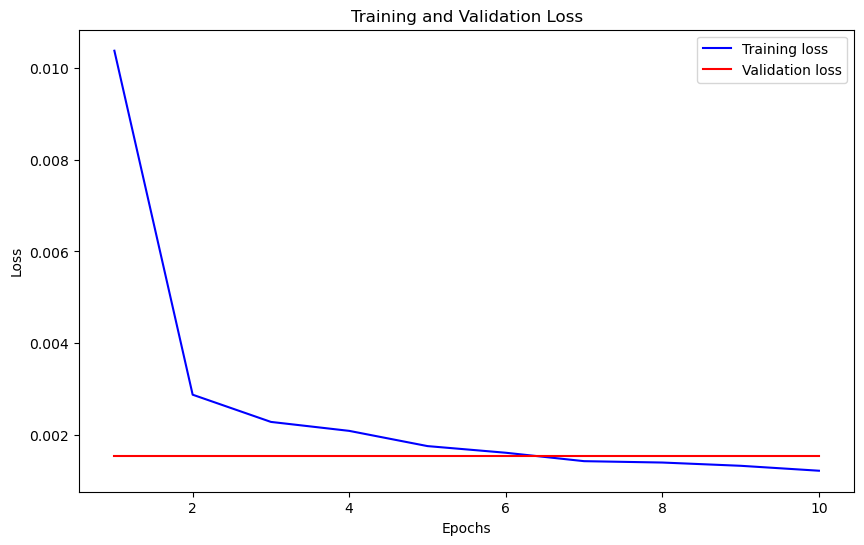

In [14]:
plot_losses(train_losses, val_losses)

# 모델 저장

In [61]:
import pickle

anti_noise_model.to('cpu')

with open('Noise_Lower_LSTM_vol_2.pkl', 'wb') as f:
    pickle.dump(anti_noise_model, f)

In [ ]:
anti_noise_model.to(device)

# 테스트

## 첫번째 배치에 대한 그래프

In [15]:
def evaluate_and_plot_with_one_batch_dataloader(model, dataloader):
    model.eval()
    for inputs, _ in dataloader:
        inputs = inputs.to(device).squeeze(-1).float()
        with torch.no_grad():
            outputs = model(inputs)
            
        input_waveform = inputs[0].cpu().numpy().flatten()
        output_waveform = outputs[0].cpu().numpy().flatten()
        combined_waveform = input_waveform + output_waveform

        original_noise = input_waveform
        predicted_anti_noise = output_waveform

        original_energy = np.sum(original_noise ** 2)

        combined_waveform = original_noise + predicted_anti_noise
        residual_energy = np.sum(combined_waveform ** 2)

        noise_reduction_percent = (1 - residual_energy / original_energy) * 100

        print(f"소음 감소율: {noise_reduction_percent:.2f}%")


        print(f"Input waveform shape: {input_waveform.shape}")
        print(f"Output waveform shape: {output_waveform.shape}")
        print(f"Input waveform first 10 values: {input_waveform[:10]}")
        print(f"Output waveform first 10 values: {output_waveform[:10]}")
        print(f"Combined waveform first 10 values: {combined_waveform[:10]}")

        
        plt.figure(figsize=(14, 6))
        plt.subplot(3, 1, 1)
        plt.plot(input_waveform, label='Original Noise')
        plt.title('Original Noise')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(output_waveform, label='Predicted Anti-Noise', color='orange', alpha=0.7)
        plt.title('Predicted Anti-Noise')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(combined_waveform, label='Combined Waveform', color='green', alpha=0.7)
        plt.title('Combined Waveform (Noise + Anti-Noise)')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        break


## 전체 배치에 대한 그래프

In [64]:
def evaluate_and_plot_with_all_batch_dataloader(model, dataloader):
    model.eval()
    
    for batch_idx, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        inputs = inputs.squeeze(-1).float()
        with torch.no_grad():
            outputs = model(inputs)
        
        for i in range(inputs.size(0)):
            input_waveform = inputs[i].cpu().numpy().flatten()
            output_waveform = outputs[i].cpu().numpy().flatten()
            combined_waveform = input_waveform + output_waveform

            print(f"Batch {batch_idx+1}, Sample {i+1}")
            print(f"Input waveform shape: {input_waveform.shape}")
            print(f"Output waveform shape: {output_waveform.shape}")
            print(f"Input waveform first 10 values: {input_waveform[:10]}")
            print(f"Output waveform first 10 values: {output_waveform[:10]}")
            print(f"Combined waveform first 10 values: {combined_waveform[:10]}")

            plt.figure(figsize=(14, 10))
            plt.subplot(3, 1, 1)
            plt.plot(input_waveform, label='Original Noise')
            plt.title('Original Noise')
            plt.legend()

            plt.subplot(3, 1, 2)
            plt.plot(output_waveform, label='Predicted Anti-Noise', color='orange', alpha=0.7)
            plt.title('Predicted Anti-Noise')
            plt.legend()

            plt.subplot(3, 1, 3)
            plt.plot(combined_waveform, label='Combined Waveform', color='green', alpha=0.7)
            plt.title('Combined Waveform (Noise + Anti-Noise)')
            plt.legend()

            plt.tight_layout()
            plt.show()


# 테스트 실행

소음 감소율: 84.94%
Input waveform shape: (1024,)
Output waveform shape: (1024,)
Input waveform first 10 values: [-0.36410522 -0.2427063  -0.13201904 -0.0718689  -0.01489258  0.05526733
  0.09524536  0.11602783  0.16067505  0.18289185]
Output waveform first 10 values: [-0.02767767  0.00703252 -0.00674264  0.01765221 -0.0099011  -0.01481869
  0.05544143  0.1367236   0.16289745  0.13988562]
Combined waveform first 10 values: [-0.3917829  -0.23567377 -0.13876168 -0.05421669 -0.02479368  0.04044865
  0.1506868   0.2527514   0.32357252  0.32277745]


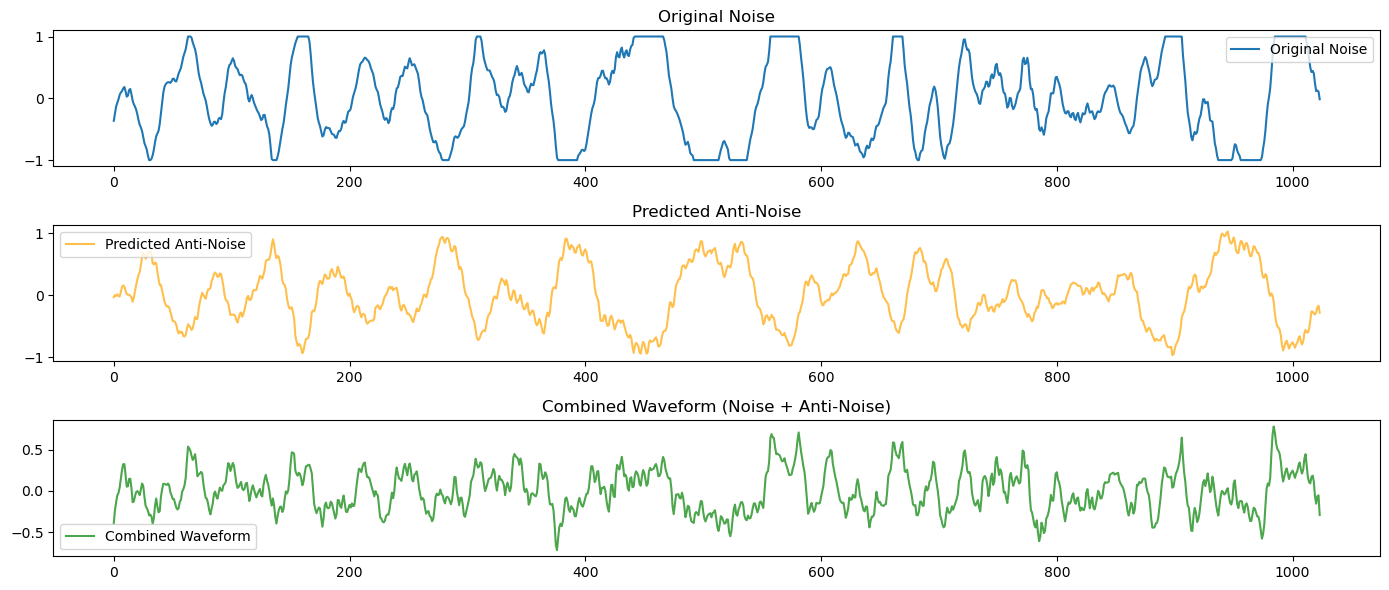

In [16]:
test_folder_path = '/Users/junggwonhee/Desktop/programing/오아시스_해커톤/project/data/plt'
test_combined_dataset = load_datasets_from_folder(test_folder_path)

test_dataloader = DataLoader(test_combined_dataset, batch_size = 64, shuffle=True)

evaluate_and_plot_with_one_batch_dataloader(anti_noise_model, test_dataloader)
# evaluate_and_plot_with_all_batch_dataloader(anti_noise_model, test_dataloader)

# 실시간 오디오 테스트

In [ ]:
def real_time_audio_processing(model, input_size=1, sample_rate=44100, chunk_size=1024):
    p = pyaudio.PyAudio()

    stream_in = p.open(format=pyaudio.paFloat32,
                       channels=1,
                       rate=sample_rate,
                       input=True,
                       frames_per_buffer=chunk_size)

    stream_out = p.open(format=pyaudio.paFloat32,
                        channels=1,
                        rate=sample_rate,
                        output=True)

    print("실시간 오디오 처리를 시작합니다...")

    try:
        while True:
            data = stream_in.read(chunk_size)
            waveform = torch.tensor(np.frombuffer(data, dtype=np.float32)).unsqueeze(0).unsqueeze(-1)

            model.eval()
            with torch.no_grad():
                anti_noise = model(waveform)

            anti_noise_data = anti_noise.squeeze().numpy().astype(np.float32).tobytes()
            stream_out.write(anti_noise_data)

    except KeyboardInterrupt:
        print("실시간 오디오 처리를 종료합니다.")
    finally:
        stream_in.stop_stream()
        stream_in.close()
        stream_out.stop_stream()
        stream_out.close()
        p.terminate()

real_time_audio_processing(anti_noise_model)
